In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
from dask.distributed import Client

In [4]:
with open('/g/g92/haridev/.dlio_profiler/configuration.yaml', 'r') as file:
    dlp_yaml = yaml.safe_load(file)

In [5]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0,dlp_yaml["APP"])
sys.path

['/usr/WS2/haridev/dlio-profiler',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages']

In [6]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/WS2/haridev/dlio-profiler/dlp_analyzer/__init__.py


In [7]:
dask_run_dir = os.path.join(dlp_yaml["APP"], "dlp_analyzer", "dask", "run_dir")
dask_run_dir

'/usr/WS2/haridev/dlio-profiler/dlp_analyzer/dask/run_dir'

In [8]:
with open (os.path.join(dask_run_dir, "scheduler.json"), "r") as f:
    dask_scheduler = json.load(f)
dask_scheduler

{'type': 'Scheduler',
 'id': 'Scheduler-89209c3b-66f7-4b23-9420-c0d0848be547',
 'address': 'tcp://134.9.71.27:10001',
 'services': {'dashboard': 8787},
 'started': 1698518019.2896266,
 'workers': {}}

In [9]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler["address"], verbose=True, 
                                log_file="./dlp.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'ruby(\d+)', time_granularity=30e6, skip_hostname=True)


In [10]:
conf = get_dlp_configuration()
conf.time_approximate

True

In [11]:
setup_logging()

In [19]:
setup_dask_cluster()

[INFO] [20:03:24] Initialized Client with 48 workers and link http://134.9.71.27:8787/status [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:604]


In [13]:
reset_dask_cluster()

[INFO] [20:03:01] Restarting all workers [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:596]


In [14]:
filename = "/p/lustre1/iopp/dlp/cosmoflow-profile-compress-meta-scale-all-512/.trace*.pfw.gz"
#filename = "/p/lustre1/iopp/dlp/cosmoflow-profile-compress-meta-scale-all-512/.trace-3*-of-512.pfw.gz"
filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"
filename = "/usr/workspace/iopp/dlio_paper_results/resnet_50_1node_4ppn/*.pfw.gz"

In [15]:
analyzer = DLPAnalyzer(filename)

[INFO] [20:03:02] Created index for 12 files [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:327]
[INFO] [20:03:02] Total size of all files are <dask.bag.core.Item object at 0x1554a7d3e580> bytes [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:329]
[INFO] [20:03:03] Loading 556 batches out of 12 files and has 9064154 lines overall [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:342]
[INFO] [20:03:13] Loaded events [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:373]
[INFO] [20:03:13] Loaded plots with slope threshold: 45 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:375]


In [16]:
analyzer.events["hostname"].unique().compute()

0    x3006c0s13b0n0
Name: hostname, dtype: string

In [17]:
#analyzer.events[["io_time","compute_time","app_io_time"]].max().compute() / 1e6

In [18]:
items = analyzer.summary()
items

[INFO] [20:03:13] Total number of events in the workload are 9064150 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:467]
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please pro

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 1 ['x3006c0s13b0n0']                                                                  │
│                ├── Processes: 4 [62695,62698]                                                                   │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 4                                                                               │
│                │   └── I/O: 34                                                                                  │
│                └── Events Recorded: 9064150                                                                     │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 1276825                                                                               │
│                    ['/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_X…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train',                        │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/val/nXXXXXXXX',                │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_X.…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX',              │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '<NA>',                                                                                      │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/val',                          │
│                    '/lus/eagle/projects/datascience/ImageNet/ILSVRC/Data/CLS-LOC/train/nXXXXXXXX/nXXXXXXXX_XX…  │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 761.168 sec                                                                  │
│                │   ├── Overall App Level I/O: 755.870 sec                                                       │
│                │   ├── Unoverlapped App I/O: 621.670 sec                                                        │
│                │   ├── Unoverlapped App Compute: 0.000 sec                                                      │
│                │   ├── Compute: 134.201 sec                                                                     │
│                │   ├── Overall I/O: 598.055 sec                                                                 │
│                │   ├── Unoverlapped I/O: 463.855 sec                                                            │
│                │   └── Unoverlapped Compute: 0.000 sec                                                          │
│                ├── Transfer size distribution by function                                                       │
│                │   ├── Function       |min   |25    |mean  |median|75    |max   |                               │
│                │   ├── opendir        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __xstat64      |NA    |nan   |n

In [19]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","pid","tid","name"])["io_time"].sum().groupby(["trange","name"]).max().groupby("name").sum().compute() / 1e6

name
__fxstat64     15.675343
__xstat64       0.361658
close          12.696269
lseek64         0.196782
open64         14.742031
opendir         1.125259
read          561.305493
Name: io_time, dtype: double[pyarrow]

In [18]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

io_time       min           0
              max     1823319
compute_time  min     2721618
              max     2742921
app_io_time   min      262239
              max    29142459
dtype: uint64[pyarrow]

In [17]:
val = analyzer.events["app_io_time"].max().compute()
val

21788614

In [22]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

105.51145505905151

In [19]:
analyzer.events["hostname"].unique().compute()[:2]

0    ruby165
1    ruby926
Name: hostname, dtype: string

In [23]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","name"])["dur"].max().sum().compute() / 1e6

3.809511

In [ ]:
analyzer.events.query("name == 'open'").groupby("trange")["dur"].max().sum().compute() / 1e6

In [21]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

cat                      name                       
POSIX                    __fxstat64                       444448241
                         __xstat64                          1041137
                         close                            342150487
                         lseek64                            5377747
                         open64                           417437820
                         opendir                            3807348
                         read                           16581944325
IO                       real_IO.iter                     311363925
                         real_IO.yield                   2708610270
communication-except-io  cpu-gpu-transfer                  37165103
compute                  model-compute-backward-prop      444288066
                         model-compute-forward-prop        50921978
Name: dur, dtype: uint64[pyarrow]

In [23]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

(0.9911281578947368,
 0.26911763157894736,
 0.28428078947368424,
 0.04696078947368421,
 0.371635)

[INFO] [19:04:51]            index         size  total_time  io_time  app_io_time
trange                                                         
28310475  237503   3435904036     9089266  3197221      9089266
28310476  557618   9055766762     5042545  2457928      5042545
28310477  603290   9753737591     2734682  2119446      2734682
28310478  655063  10582738192     3606051  2089019      3606051
28310479  683200  11006549057     4613653  1930037      4613653 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]
[INFO] [19:04:51]            index         size  total_time  io_time  app_io_time
trange                                                         
28310475  237503   3435904036     9089266  3197221      9089266
28310476  557618   9055766762     5042545  2457928      5042545
28310477  603290   9753737591     2734682  2119446      2734682
28310478  655063  10582738192     3606051  2089019      3606051
28310479  683200  11006549057     4613653  1930037      4613653 [/usr/WS2

(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='Timeline (sec)', ylabel='I/O Time (sec)'>)

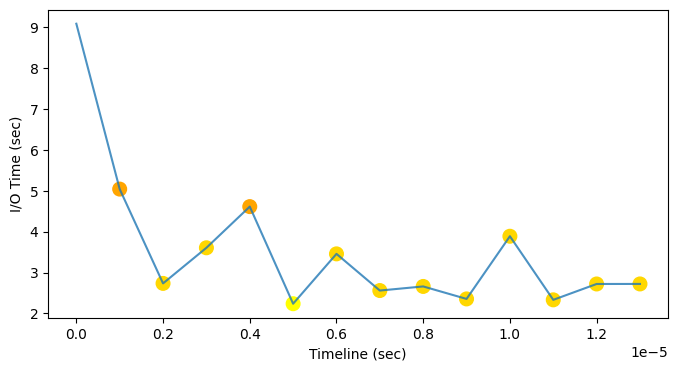

In [21]:
analyzer.plots.bottleneck_timeline(figsize=(8, 4))

In [ ]:
analyzer.plots.bw_timeline(figsize=(4, 4), unit='KB')

[INFO] [13:52:38]             index           size  total_time  io_time  app_io_time
trange                                                            
21229401  6398146  6057549130908    21788614  1320738     21788614
21229402  5598058  6039041094497     5366465   299441      5366465 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]


<Axes: xlabel='Transfer Sizes', ylabel='Frequency'>

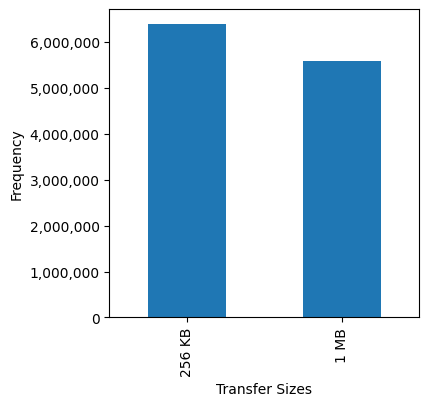

In [35]:
analyzer.plots.xfer_size_distribution(figsize=(4, 4))